In [164]:
import numpy as np
import math
import os
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 准备部分

In [165]:
UNCLASSIFIED = False
NOISE = 0.1 # 设置噪声点

In [166]:
def loadDataSet(fileName):
    '''载入文件，并读取相应的数据集'''
    root = './data/'
    filename = fileName
    file_path = os.path.join(root, filename + '.mat')
    dataSet = []
    file = sio.loadmat(file_path)

    if filename == 'smile':
        dataSet = file['smile']
    elif filename == 'moon':
        dataSet = file['a']
    elif filename == '2d4c':
        dataSet = file['a']
    elif filename == 'long':
        dataSet = file['long1']
    elif filename == 'sizes5':
        dataSet = file['sizes5']
    elif filename == 'spiral':
        dataSet = file['spiral']
    elif filename == 'square1':
        dataSet = file['square1']
    elif filename == 'square4':
        dataSet = file['b']
    dataSet = dataSet.tolist()
    return dataSet

In [167]:
def dist(a, b):
    '''计算两个向量的欧氏距离'''
    return math.sqrt(np.power(a - b, 2).sum())

In [168]:
def eps_neighbor(a, b, eps):
    '''判断两个向量之间的距离是否在epsilon内'''
    return dist(a, b) < eps

In [169]:
def region_query(data, pointId, eps):
    '''找到在epsilon范围内的点的id'''
    nPoints = data.shape[1]
    seeds = []
    for i in range(nPoints):
        if eps_neighbor(data[:, pointId], data[:, i], eps):
            seeds.append(i)
    return seeds

In [170]:
def expand_cluster(data, clusterResult, pointId, clusterId, eps, minPts):
    '''判断是否成功聚类，成功的持续扩张，不成功标为噪声点'''
    seeds = region_query(data, pointId, eps)
    if len(seeds) < minPts:  # 不满足minPts条件的为噪声点
        clusterResult[pointId] = NOISE
        return False
    else:
        clusterResult[pointId] = clusterId  # 划分到该簇
        for seedId in seeds:
            clusterResult[seedId] = clusterId

        while len(seeds) > 0:  # 持续扩张
            currentPoint = seeds[0]
            queryResults = region_query(data, currentPoint, eps)
            if len(queryResults) >= minPts:
                for i in range(len(queryResults)):
                    resultPoint = queryResults[i]
                    if clusterResult[resultPoint] == UNCLASSIFIED:  # UNCLASSIFIED = False
                        seeds.append(resultPoint)
                        clusterResult[resultPoint] = clusterId
                    elif clusterResult[resultPoint] == NOISE:
                        clusterResult[resultPoint] = clusterId
            seeds = seeds[1:]
        return True

In [171]:
def dbscan(data, eps, minPts):
    '''DBSCAN,输入数据集，半径大小，最小点数，输出簇id，簇数目。'''   
    clusterId = 1
    nPoints = data.shape[1]
    clusterResult = [UNCLASSIFIED] * nPoints
    for pointId in range(nPoints):
        point = data[:, pointId]
        if clusterResult[pointId] == UNCLASSIFIED:
            if expand_cluster(data, clusterResult, pointId, clusterId, eps, minPts):
                clusterId = clusterId + 1
    return clusterResult, clusterId - 1

In [172]:
def select_eps(data,k):
    '''找到最佳的epsilon'''
    k_dist = []  # 记录每个点的k-dist
    for i in range(data.shape[0]):
        dist = (((data[i] - data)**2).sum(axis=1)**0.5)  # 计算欧氏距离
        dist.sort()  # 对距离进行升序排序
        k_dist.append(dist[k])  # 找出第k个近邻到数据点data[i]的距离,每个数据点都有这个距离，凑成k_dist序列
    return np.array(k_dist)

In [173]:
def plotFeature(name, data, clusters, clusterNum):
    '''绘制分类结果'''
    nPoints = data.shape[1]
    matClusters = np.mat(clusters).transpose()
    fig = plt.figure(name)
    scatterColors = ['black', 'blue', 'green',
                     'yellow', 'red', 'purple', 'orange', 'brown']
    ax = fig.add_subplot(111)
    plt.title(name)
    for i in range(clusterNum + 1):
        colorSytle = scatterColors[i % len(scatterColors)]
        subCluster = data[:, np.nonzero(matClusters[:, 0].A == i)]
        ax.scatter(subCluster[0, :].flatten().A[0],
                   subCluster[1, :].flatten().A[0], c=colorSytle, s=50)

# 2d4c

## 绘制k-distance图寻找最佳epsilon

[[-8.95016  -5.57867   0.      ]
 [-8.81747  -4.82428   0.      ]
 [-6.54513   2.2691    0.      ]
 ...
 [ 0.364815 -8.07657   3.      ]
 [-0.247553 -8.30315   3.      ]
 [-2.8361   -9.82205   3.      ]]
1572


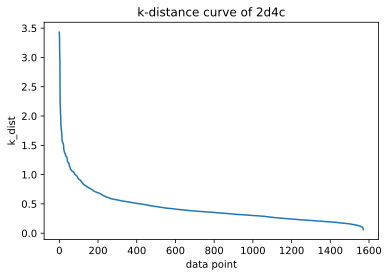

In [174]:
_2d4c = '2d4c'
data1 = loadDataSet(_2d4c)
data1_ndarray = np.array(data1)
print(data1_ndarray)  # print(data1_ndarray)

k = 5  # k取（2*维数-1）
k_dist = select_eps(data1_ndarray, k)
k_dist.sort()
print(k_dist.shape[0])
plt.title('k-distance curve of '+ _2d4c)
plt.xlabel('data point')
plt.ylabel('k_dist')
plt.plot(np.arange(k_dist.shape[0]), k_dist[::-1])
plt.savefig('./pictures/2d4c_eps.png', dpi=200, bbox_inches='tight')

## 聚类，绘制结果

cluster Numbers =  4


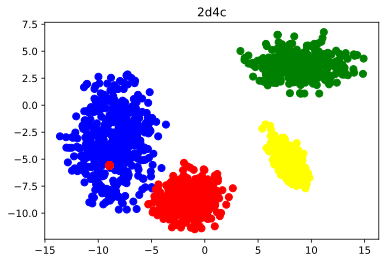

In [175]:
data1 = np.mat(data1).transpose()
clusters, clusterNum = dbscan(data1, 1, 6)
print("cluster Numbers = ", clusterNum)  # print(clusters Number)

plotFeature(_2d4c, data1, clusters, clusterNum)
# plt.savefig('./pictures/2d4c_withoutnoise.png', dpi=200, bbox_inches='tight')
plt.savefig('./pictures/2d4c.png', dpi=200, bbox_inches='tight')

# long

## 绘制k-distance图寻找最佳epsilon

[[ 0.253393   -0.00455816  0.        ]
 [ 0.83422    -0.0170388   0.        ]
 [ 0.915511    0.0706192   0.        ]
 ...
 [ 1.54997     1.19172     1.        ]
 [-0.0859812   0.958217    1.        ]
 [-0.123228    1.09792     1.        ]]
1000


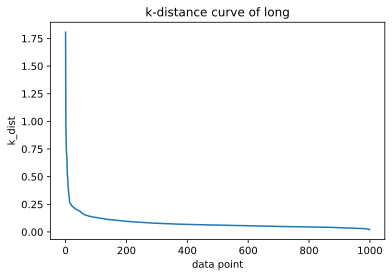

In [176]:
long = 'long'
data2 = loadDataSet(long)
data2_ndarray = np.array(data2)
print(data2_ndarray)  # print(data2_ndarray)

k = 5  # k取（2*维数-1）
k_dist = select_eps(data2_ndarray, k)
k_dist.sort()
print(k_dist.shape[0])
plt.title('k-distance curve of '+ long)
plt.xlabel('data point')
plt.ylabel('k_dist')
plt.plot(np.arange(k_dist.shape[0]), k_dist[::-1])
plt.savefig('./pictures/long_eps.png', dpi=200, bbox_inches='tight')

## 聚类，绘制结果

cluster Numbers =  2


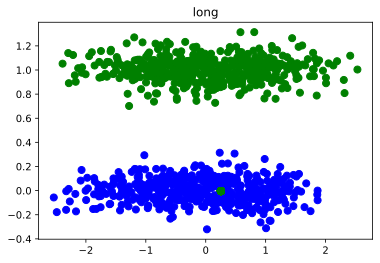

In [177]:
data2 = np.mat(data2).transpose()
clusters, clusterNum = dbscan(data2, 0.25, 6)
print("cluster Numbers = ", clusterNum)  # print(cluster number)

plotFeature(long, data2, clusters, clusterNum)
# plt.savefig('./pictures/long_withoutnoise.png', dpi=200, bbox_inches='tight')
plt.savefig('./pictures/long.png', dpi=200, bbox_inches='tight')

# moon

## 绘制k-distance图寻找最佳epsilon

[[-9.94500e-01  1.19080e+01  0.00000e+00]
 [-9.70900e-01  1.18617e+01  0.00000e+00]
 [-9.74500e-01  1.18870e+01  0.00000e+00]
 [-1.02690e+00  1.18715e+01  0.00000e+00]
 [-9.69300e-01  1.18586e+01  0.00000e+00]
 [-9.23500e-01  1.19385e+01  0.00000e+00]
 [-9.21700e-01  1.19283e+01  0.00000e+00]
 [-8.70900e-01  1.19647e+01  0.00000e+00]
 [-8.67900e-01  1.19676e+01  0.00000e+00]
 [-9.27100e-01  1.19441e+01  0.00000e+00]
 [-7.93400e-01  1.19765e+01  0.00000e+00]
 [-8.05400e-01  1.19652e+01  0.00000e+00]
 [-7.72300e-01  1.19895e+01  0.00000e+00]
 [-8.01500e-01  1.19537e+01  0.00000e+00]
 [-7.79400e-01  1.20078e+01  0.00000e+00]
 [-6.99400e-01  1.20108e+01  0.00000e+00]
 [-6.79600e-01  1.20060e+01  0.00000e+00]
 [-6.85000e-01  1.20099e+01  0.00000e+00]
 [-7.06400e-01  1.19963e+01  0.00000e+00]
 [-7.23900e-01  1.20033e+01  0.00000e+00]
 [-5.87700e-01  1.20765e+01  0.00000e+00]
 [-5.83800e-01  1.20579e+01  0.00000e+00]
 [-6.09900e-01  1.20302e+01  0.00000e+00]
 [-6.21300e-01  1.20590e+01  0.000

210


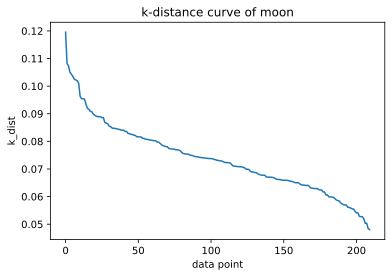

In [178]:
moon = 'moon'
data3 = loadDataSet(moon)
data3_ndarray = np.array(data3)
print(data3_ndarray)  # print(data3_ndarray)

k = 5  # k取（2*维数-1）
k_dist = select_eps(data3_ndarray, k)
k_dist.sort()
print(k_dist.shape[0])
plt.title('k-distance curve of '+ moon)
plt.xlabel('data point')
plt.ylabel('k_dist')
plt.plot(np.arange(k_dist.shape[0]), k_dist[::-1])
plt.savefig('./pictures/moon_eps.png', dpi=200, bbox_inches='tight')

## 聚类，绘制结果

cluster Numbers =  2


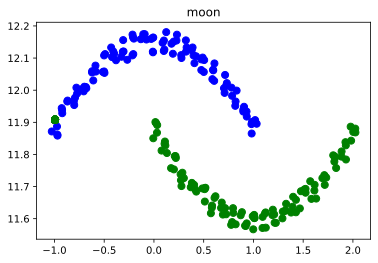

In [179]:
data3 = np.mat(data3).transpose()
clusters, clusterNum = dbscan(data3, 0.5, 6)
print("cluster Numbers = ", clusterNum)  # print(cluster number)

plotFeature(moon, data3, clusters, clusterNum)
# plt.savefig('./pictures/moon_withoutnoise.png', dpi=200, bbox_inches='tight')
plt.savefig('./pictures/moon.png', dpi=200, bbox_inches='tight')

# sizes5

## 绘制k-distance图寻找最佳epsilon

[[10.8869    8.90031   0.      ]
 [10.2351   14.3846    0.      ]
 [ 8.42297  10.9991    0.      ]
 ...
 [ 1.97011   0.119301  3.      ]
 [-1.13789  -3.62316   3.      ]
 [ 1.59897  -0.911978  3.      ]]
1000


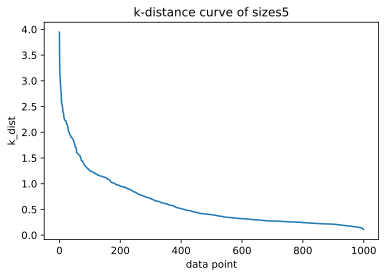

In [180]:
sizes5 = 'sizes5'
data4 = loadDataSet(sizes5)
data4_ndarray = np.array(data4)
print(data4_ndarray)  # print(data4_ndarray)

k = 5  # k取（2*维数-1）
k_dist = select_eps(data4_ndarray, k)
k_dist.sort()
print(k_dist.shape[0])
plt.title('k-distance curve of '+ sizes5)
plt.xlabel('data point')
plt.ylabel('k_dist')
plt.plot(np.arange(k_dist.shape[0]), k_dist[::-1])
plt.savefig('./pictures/sizes5_eps.png', dpi=200, bbox_inches='tight')

## 聚类，绘制结果

cluster Numbers =  4


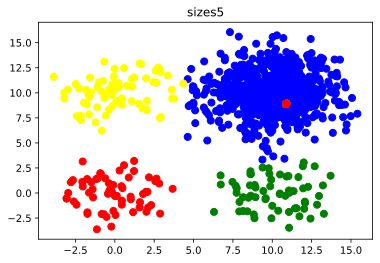

In [181]:
data4 = np.mat(data4).transpose()
clusters, clusterNum = dbscan(data4, 2, 17)  # print(cluster number)

print("cluster Numbers = ", clusterNum)
plotFeature(sizes5, data4, clusters, clusterNum)
# plt.savefig('./pictures/sizes5_withoutnoise.png', dpi=200, bbox_inches='tight')
plt.savefig('./pictures/sizes5.png', dpi=200, bbox_inches='tight')

# smile

## 绘制k-distance图寻找最佳epsilon

[[0.1764  0.6216  0.     ]
 [0.16667 0.60904 0.     ]
 [0.16307 0.60716 0.     ]
 [0.168   0.60287 0.     ]
 [0.14713 0.59026 0.     ]
 [0.18145 0.58371 0.     ]
 [0.16676 0.58569 0.     ]
 [0.15674 0.56957 0.     ]
 [0.16136 0.54593 0.     ]
 [0.16777 0.55836 0.     ]
 [0.15154 0.54837 0.     ]
 [0.18009 0.53146 0.     ]
 [0.17714 0.54592 0.     ]
 [0.18236 0.53499 0.     ]
 [0.17844 0.52232 0.     ]
 [0.17691 0.52232 0.     ]
 [0.17659 0.51863 0.     ]
 [0.19225 0.5121  0.     ]
 [0.20227 0.48165 0.     ]
 [0.19046 0.50119 0.     ]
 [0.21236 0.48646 0.     ]
 [0.19892 0.47164 0.     ]
 [0.22665 0.4691  0.     ]
 [0.20038 0.46983 0.     ]
 [0.21593 0.47831 0.     ]
 [0.22119 0.46494 0.     ]
 [0.23104 0.46358 0.     ]
 [0.24418 0.44403 0.     ]
 [0.23885 0.43274 0.     ]
 [0.23388 0.42328 0.     ]
 [0.24512 0.41104 0.     ]
 [0.25294 0.4298  0.     ]
 [0.24577 0.415   0.     ]
 [0.25845 0.39804 0.     ]
 [0.27411 0.412   0.     ]
 [0.2716  0.39817 0.     ]
 [0.27648 0.39242 0.     ]
 

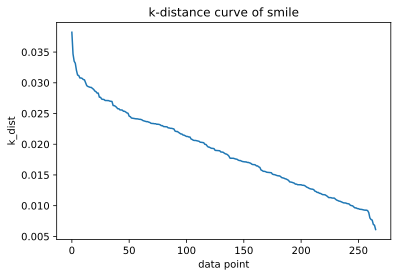

In [182]:
smile = 'smile'
data5 = loadDataSet(smile)
data5_ndarray = np.array(data5)
print(data5_ndarray)  # print(data5_ndarray)

k = 5  # k取（2*维数-1）
k_dist = select_eps(data5_ndarray, k)
k_dist.sort()
print(k_dist.shape[0])
plt.title('k-distance curve of '+ smile)
plt.xlabel('data point')
plt.ylabel('k_dist')
plt.plot(np.arange(k_dist.shape[0]), k_dist[::-1])
plt.savefig('./pictures/smile_eps.png', dpi=200, bbox_inches='tight')

## 聚类，绘制结果

cluster Numbers =  3


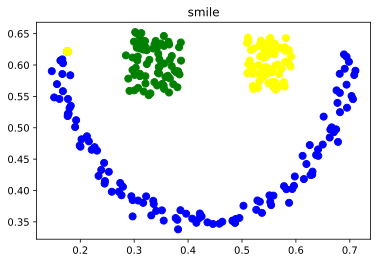

In [183]:
data5 = np.mat(data5).transpose()
clusters, clusterNum = dbscan(data5, 0.5, 6)
print("cluster Numbers = ", clusterNum)  # print(clusters)

plotFeature(smile, data5, clusters, clusterNum)
# plt.savefig('./pictures/smile_withoutnoise.png', dpi=200, bbox_inches='tight')
plt.savefig('./pictures/smile.png', dpi=200, bbox_inches='tight')

# spiral

## 绘制k-distance图寻找最佳epsilon

[[ 1.5        0.         0.       ]
 [ 1.50973    0.0284611  0.       ]
 [ 1.51892    0.0572891  0.       ]
 ...
 [ 6.45966   -0.365675   1.       ]
 [ 6.4754    -0.244232   1.       ]
 [ 6.48885   -0.122326   1.       ]]
1000


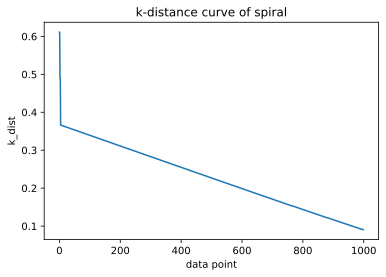

In [184]:
spiral = 'spiral'
data6 = loadDataSet(spiral)
data6_ndarray = np.array(data6)
print(data6_ndarray)  # print(data6_ndarray)

k = 5  # k取（2*维数-1）
k_dist = select_eps(data6_ndarray, k)
k_dist.sort()
print(k_dist.shape[0])
plt.title('k-distance curve of '+ spiral)
plt.xlabel('data point')
plt.ylabel('k_dist')
plt.plot(np.arange(k_dist.shape[0]), k_dist[::-1])
plt.savefig('./pictures/spiral_eps.png', dpi=200, bbox_inches='tight')

## 聚类，绘制结果

cluster Numbers =  2


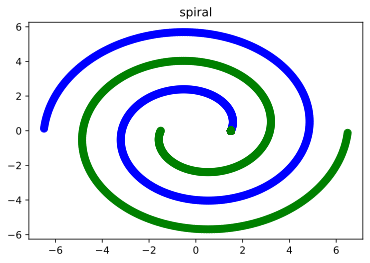

In [185]:
data6 = np.mat(data6).transpose()
clusters, clusterNum = dbscan(data6, 0.36, 4)
print("cluster Numbers = ", clusterNum)  # print(cluster number)

plotFeature(spiral, data6, clusters, clusterNum)
# plt.savefig('./pictures/spiral_withoutnoise.png', dpi=200, bbox_inches='tight')
plt.savefig('./pictures/spiral.png', dpi=200, bbox_inches='tight')

# square1

## 绘制k-distance图寻找最佳epsilon

[[10.9185    4.88961   0.      ]
 [12.4454    9.74354   0.      ]
 [11.4869    8.48109   0.      ]
 ...
 [-1.68494  -0.190611  3.      ]
 [-5.70059  -1.22378   3.      ]
 [ 1.76609   0.397725  3.      ]]
1000


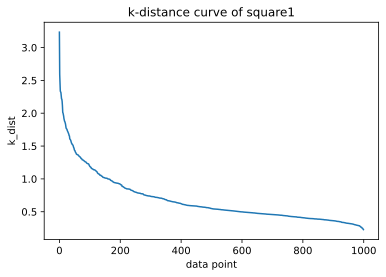

In [186]:
square1 = 'square1'
data7 = loadDataSet(square1)
data7_ndarray = np.array(data7)
print(data7_ndarray)  # print(data7_ndarray)

k = 5  # k取（2*维数-1）
k_dist = select_eps(data7_ndarray, k)
k_dist.sort()
print(k_dist.shape[0])
plt.title('k-distance curve of '+ square1)
plt.xlabel('data point')
plt.ylabel('k_dist')
plt.plot(np.arange(k_dist.shape[0]), k_dist[::-1])
plt.savefig('./pictures/square1_eps.png', dpi=200, bbox_inches='tight')

## 聚类，绘制结果

cluster Numbers =  4


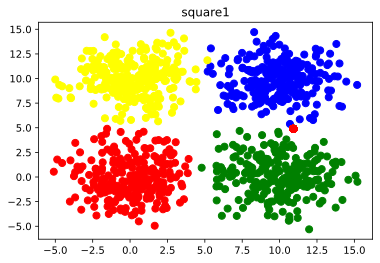

In [187]:
data7 = np.mat(data7).transpose()
clusters, clusterNum = dbscan(data7, 1.4, 6)
print("cluster Numbers = ", clusterNum)  # print(cluster number)

plotFeature(square1, data7, clusters, clusterNum)
# plt.savefig('./pictures/square1_withoutnoise.png', dpi=200, bbox_inches='tight')
plt.savefig('./pictures/square1.png', dpi=200, bbox_inches='tight')

# square4

## 绘制k-distance图寻找最佳epsilon

[[ 5.9181  9.5351  0.    ]
 [ 4.3452  4.5311  0.    ]
 [ 7.0212  7.5508  0.    ]
 ...
 [ 2.6617 -1.5776  3.    ]
 [-4.2408 -0.982   3.    ]
 [ 2.5656 -0.084   3.    ]]
1000


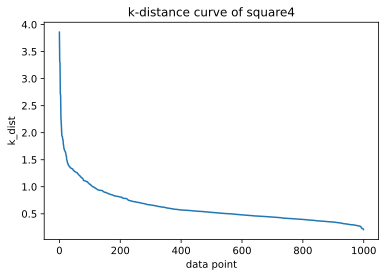

In [188]:
square4 = 'square4'
data8 = loadDataSet(square4)
data8_ndarray = np.array(data8)
print(data8_ndarray)  # print(data8_ndarray)

k = 5  # k取（2*维数-1）
k_dist = select_eps(data8_ndarray, k)
k_dist.sort()
print(k_dist.shape[0])
plt.title('k-distance curve of '+ square4)
plt.xlabel('data point')
plt.ylabel('k_dist')
plt.plot(np.arange(k_dist.shape[0]), k_dist[::-1])
plt.savefig('./pictures/square4_eps.png', dpi=200, bbox_inches='tight')

## 聚类，绘制结果

cluster Numbers =  4


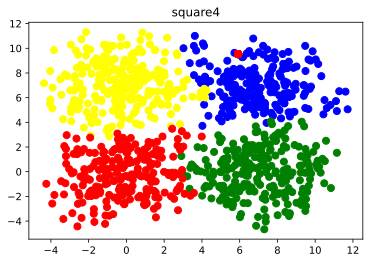

In [189]:
data8 = np.mat(data8).transpose()
clusters, clusterNum = dbscan(data8, 1, 5)
print("cluster Numbers = ", clusterNum)  # print(cluster number)

plotFeature(square4, data8, clusters, clusterNum)
# plt.savefig('./pictures/square4_withoutnoise.png', dpi=200, bbox_inches='tight')
plt.savefig('./pictures/square4.png', dpi=200, bbox_inches='tight')